In [2]:
]activate .

In [1]:
]st

    Status `~/Dokumente/Programmieren/julia_projects/esdl_call/Project.toml`
  [8f4d0f93]   Conda v1.1.1
  [359177bc] ↑ ESDL v0.4.15 #master (https://github.com/esa-esdl/ESDL.jl) ⇒ v0.5.0 [`~/.julia/dev/ESDL`]
  [d555b242] - ESDLPlots v0.1.4 #master (https://github.com/esa-esdl/ESDLPlots.jl)
  [98b081ad] + Literate v1.1.0
  [438e738f]   PyCall v1.18.5
  [b1dc47e8] + SentinelMissings v0.1.3 #master (https://github.com/meggart/SentinelMissings.jl.git)
  [bbac0a1f] + WeightedOnlineStats v0.3.0
    Status `~/Dokumente/Programmieren/julia_projects/esdl_call/Manifest.toml`
  [359177bc] ↑ ESDL v0.4.15 #master (https://github.com/esa-esdl/ESDL.jl) ⇒ v0.5.0 [`~/.julia/dev/ESDL`]
  [d555b242] - ESDLPlots v0.1.4 #master (https://github.com/esa-esdl/ESDLPlots.jl)
  [98b081ad] + Literate v1.1.0
  [b1dc47e8] + SentinelMissings v0.1.3 #master (https://github.com/meggart/SentinelMissings.jl.git)
  [bbac0a1f] ↑ WeightedOnlineStats v0.1.8 ⇒ v0.3.0


In [2]:
using Revise, ESDL

┌ Info: Recompiling stale cache file /home/qe89hep/.julia/compiled/v1.1/ESDL/2Q02O.ji for ESDL [359177bc-a543-11e8-11b7-bb015dba3358]
└ @ Base loading.jl:1184


### Bugs discovered during the meeting

- error during mapCube was caused by misinterpreting `None` in the cube chunks entry -> was fixed in code but it is strongly recommended to alway write the chunk size to help speed up the processing
- error in `YearStepRange` was caused by this implementation of `in` https://github.com/JuliaLang/julia/blob/80516ca20297a67b996caa08c38786332379b6a5/base/range.jl#L976 which obviously does not work for my custom range. Was fixed by adding a special method

In [3]:
c=Cube("/home/qe89hep/Daten/esdl/s1cube_1dayall/")

ESDL data cube at /home/qe89hep/Daten/esdl/s1cube_1dayall/
Spatial resolution:  1008x1071 at 0.00017966305690109152 degrees.
Temporal resolution: 2014-10-03 to 2019-07-11 at 1daily time steps
Variables:           sentinel1_vh_a sentinel1_vh_d sentinel1_vv_a sentinel1_vv_d 


In [56]:
methodswith(typeof(d))

0-element Array{Method,1}

In [5]:
d = getCubeData(c)

Data Cube view with the following dimensions
Lon                 Axis with 1008 Elements from -179.99991016847156 to -179.81898947017217
Lat                 Axis with 1071 Elements from 89.99991016847154 to 89.80767069758738
Time                Axis with 1346 Elements from 2014-10-04 to 2018-06-11
Variable            Axis with 2 elements: sentinel1_VH sentinel1_VV 
Total size: 13.53 GB


In [30]:
eachsl

search: eachslice



```
eachslice(A::AbstractArray; dims)
```

Create a generator that iterates over dimensions `dims` of `A`, returning views that select all the data from the other dimensions in `A`.

Only a single dimension in `dims` is currently supported. Equivalent to `(view(A,:,:,...,i,:,: ...)) for i in axes(A, dims))`, where `i` is in position `dims`.

See also [`eachrow`](@ref), [`eachcol`](@ref), and [`selectdim`](@ref).

!!! compat "Julia 1.1"
    This function requires at least Julia 1.1.



## Find out which time steps contain values

In [17]:
@time a = d[:,:,1,1]
@time ts = d[100,100,:,1]
ind = .!ismissing.(ts)
findall(ind)

  0.010627 seconds (108 allocations: 14.419 MiB, 75.29% gc time)
  0.032796 seconds (5.01 k allocations: 366.359 KiB)


109-element Array{Int64,1}:
  411
  723
  747
  771
  795
  819
  842
  875
  887
  890
  899
  902
  911
    ⋮
 1304
 1307
 1310
 1313
 1316
 1319
 1322
 1325
 1328
 1334
 1337
 1340

In [6]:
hasvalues = mapslices(i->any(!ismissing,i),d,("Lon","Lat","Var"))

┌ Warning: There are still cache misses
└ @ ESDL.DAT /home/qe89hep/.julia/packages/ESDL/bKX8H/src/DAT/DAT.jl:542
┌ Warning: There are compressed caches misses, you may want to use a different cube chunking
└ @ ESDL.DAT /home/qe89hep/.julia/packages/ESDL/bKX8H/src/DAT/DAT.jl:543


InterruptException: InterruptException:

In [7]:
inds = findall(!ismissing,hasvalues[:]);

UndefVarError: UndefVarError: hasvalues not defined

In [32]:
newtimeax = TimeAxis(d.timeAxis.values[ind])

Time                Axis with 109 Elements from 2015-11-18 to 2018-06-05

In [33]:
function copyfun(xout,xin,inds)
    xout.=xin[inds]
end

copyfun (generic function with 1 method)

### Remap to new time axis

In [35]:
indims = InDims("Time")
outdims = OutDims(newtimeax)
cubeshort = mapCube(copyfun,d,ind,indims=indims,outdims=outdims,max_cache=1e8)

Memory mapped cube with the following dimensions
Time                Axis with 109 Elements from 2015-11-18 to 2018-06-05
Lon                 Axis with 1008 Elements from -179.99991016847156 to -179.81898947017217
Lat                 Axis with 1071 Elements from 89.99991016847154 to 89.80767069758738
Variable            Axis with 2 elements: sentinel1_VH sentinel1_VV 
Total size: 1.1 GB


In [57]:
shortdata = getCubeData(cubeshort)

MethodError: MethodError: no method matching getCubeData(::ESDL.Cubes.MmapCube{Float32,4})
Closest candidates are:
  getCubeData(!Matched::ESDL.CubeAPI.UCube; variable, time, latitude, longitude, region) at /home/qe89hep/.julia/packages/ESDL/bKX8H/src/CubeAPI/CubeAPI.jl:468
  getCubeData(!Matched::ESDL.CubeAPI.UCube, !Matched::Array{T<:AbstractString,1}, !Matched::Tuple{TimeType,TimeType}, !Matched::Tuple{Real,Real}, !Matched::Tuple{Real,Real}) where T<:AbstractString at /home/qe89hep/.julia/packages/ESDL/bKX8H/src/CubeAPI/CubeAPI.jl:625
  getCubeData(!Matched::ESDL.CubeAPI.UCube, !Matched::Any, !Matched::Any, !Matched::Any, !Matched::Any) at /home/qe89hep/.julia/packages/ESDL/bKX8H/src/CubeAPI/CubeAPI.jl:517

In [36]:
#Check a random time entry
cubeshort[:,500,500,:]

109×2 Array{Union{Missing, Float32},2}:
 0.0450496  0.192162 
 0.0306514  0.0636495
 0.0386226  0.101702 
 0.0434581  0.18507  
 0.0363384  0.108583 
 0.0198827  0.0842303
 0.0294457  0.097366 
 0.0172256  0.111951 
 0.0263031  0.108248 
 0.0244575  0.082157 
 0.0424384  0.139837 
 0.0252525  0.0802815
 0.0369655  0.132269 
 ⋮                   
 0.0298996  0.0825622
 0.0329341  0.187466 
 0.0516884  0.121712 
 0.0481689  0.12604  
 0.0359798  0.0961182
 0.0428461  0.227843 
 0.0419421  0.0731331
 0.0397423  0.10912  
 0.0535314  0.0767276
 0.0408396  0.0778528
 0.0402203  0.175066 
 0.0378538  0.128366 

### Compute MSC by aggregating per month

- we first generate a month mask to now for each time step which month it belongs to and afterwards do the aggregation time series by time series

In [38]:
using Dates
monthmask = month.(newtimeax.values);
monthcount = zeros(Int,12) #preallocated buffer

12-element Array{Int64,1}:
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0

In [39]:
function aggmonth(xout,xin,monthmask,monthcount)
    fill!(monthcount,0)
    fill!(xout,0.0)
    # First aggregate
    for (v,mm) in zip(xin,monthmask)
        if !ismissing(v)
            xout[mm] += v
            monthcount[mm] += 1
        end
    end
    # And divide by the number of obs if there are any
    xout .= xout./monthcount
    replace!(xout,NaN=>missing)
end

aggmonth (generic function with 1 method)

In [40]:
indims  = InDims("Time")
outdims = OutDims(RangeAxis("Month",1:12))
msc = mapCube(aggmonth,cubeshort,monthmask,monthcount,indims=indims,outdims=outdims,max_cache=1e8)

Memory mapped cube with the following dimensions
Month               Axis with 12 Elements from 1 to 12
Lon                 Axis with 1008 Elements from -179.99991016847156 to -179.81898947017217
Lat                 Axis with 1071 Elements from 89.99991016847154 to 89.80767069758738
Variable            Axis with 2 elements: sentinel1_VH sentinel1_VV 
Total size: 123.55 MB


In [44]:
using GR

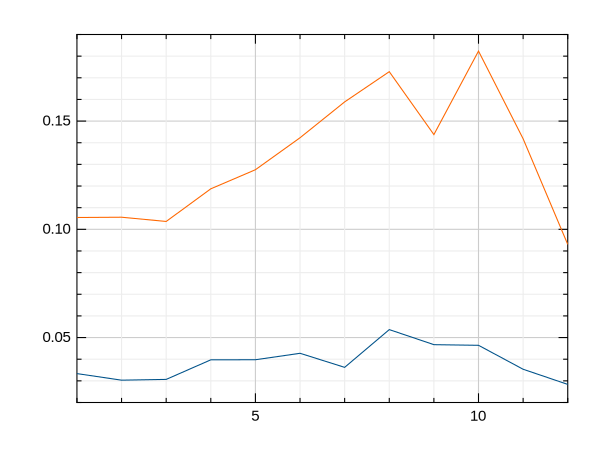

In [48]:
plot(replace(msc[:,500,500,:],missing=>NaN))

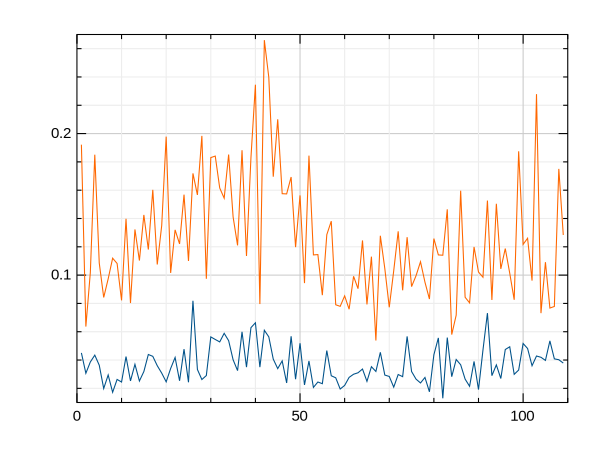

In [47]:
plot(replace(cubeshort[:,500,500,:], missing =>NaN))

In [51]:
cubeshort.timeAxis

ErrorException: type MmapCube has no field timeAxis